In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor

import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA


In [2]:
pip install pmdarima

In [ ]:
pip install scikeras

In [ ]:
from google.colab import files
files.upload()

In [32]:
df=pd.read_csv("daily-website-visitors.csv")
df["Date"]=pd.to_datetime(df["Date"])
df=df[["Date","First.Time.Visits"]]
df.set_index("Date",inplace=True)
df.head()

,First.Time.Visits
Date,
2014-09-14,1430
2014-09-15,2297
2014-09-16,2352
2014-09-17,2327
2014-09-18,2130


In [33]:
data=df.copy()

In [20]:
scaler = MinMaxScaler()
df['First.Time.Visits'] = scaler.fit_transform(df[['First.Time.Visits']])

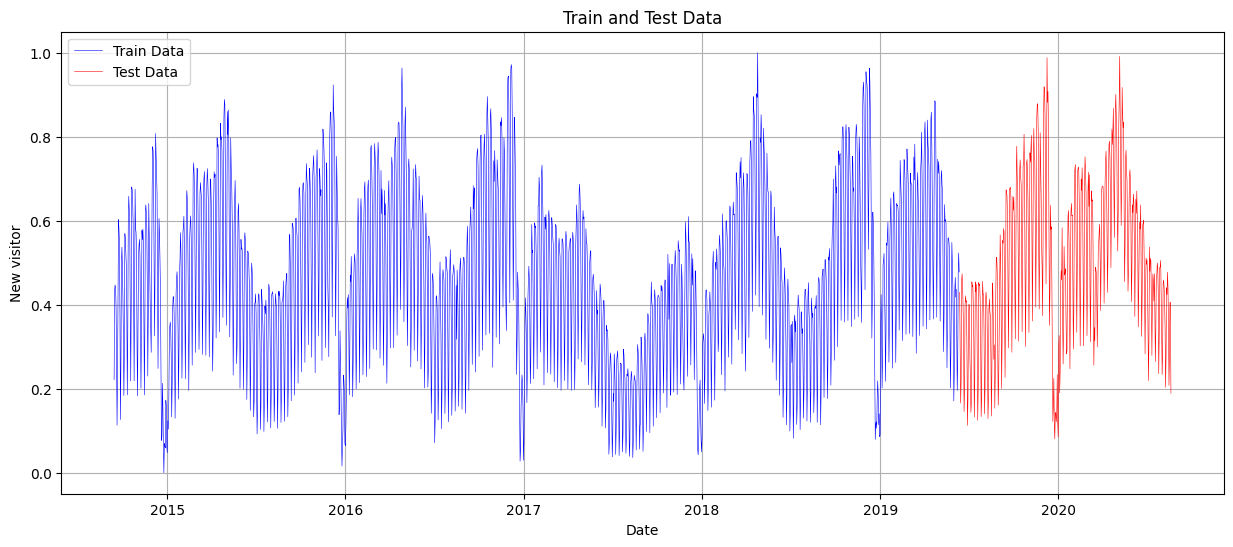

In [21]:
# Split the data into training and testing sets
train_size = 0.8
train, test = train_test_split(df, test_size=1 - train_size, shuffle=False)

# Plot both the training and testing sets in a single flow
plt.figure(figsize=(15, 6))

# Plot the training data
plt.plot(train['First.Time.Visits'], label='Train Data', color='blue',linewidth=0.4)

# Plot the testing data
plt.plot(test['First.Time.Visits'], label='Test Data', color='red',linewidth=0.4)

plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('New visitor')  # Replace with the actual metric name
plt.legend()
plt.grid(True)
plt.show()



In [22]:
# Define a function to create sequences for the GRU model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Adjust the sequence length as needed
X_train, y_train = create_sequences(train.values, seq_length)
X_test, y_test = create_sequences(test.values, seq_length)

In [23]:
# Build and train the GRU model
model = Sequential()
model.add(GRU(units=64, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Epoch 1/50
27/27 - 2s - loss: 0.1458 - 2s/epoch - 77ms/step
Epoch 2/50
27/27 - 0s - loss: 0.0319 - 241ms/epoch - 9ms/step
Epoch 3/50
27/27 - 0s - loss: 0.0279 - 224ms/epoch - 8ms/step
Epoch 4/50
27/27 - 0s - loss: 0.0264 - 229ms/epoch - 8ms/step
Epoch 5/50
27/27 - 0s - loss: 0.0252 - 250ms/epoch - 9ms/step
Epoch 6/50
27/27 - 0s - loss: 0.0240 - 241ms/epoch - 9ms/step
Epoch 7/50
27/27 - 0s - loss: 0.0227 - 230ms/epoch - 9ms/step
Epoch 8/50
27/27 - 0s - loss: 0.0215 - 238ms/epoch - 9ms/step
Epoch 9/50
27/27 - 0s - loss: 0.0202 - 350ms/epoch - 13ms/step
Epoch 10/50
27/27 - 1s - loss: 0.0190 - 1s/epoch - 39ms/step
Epoch 11/50
27/27 - 0s - loss: 0.0169 - 404ms/epoch - 15ms/step
Epoch 12/50
27/27 - 0s - loss: 0.0159 - 403ms/epoch - 15ms/step
Epoch 13/50
27/27 - 0s - loss: 0.0137 - 415ms/epoch - 15ms/step
Epoch 14/50
27/27 - 0s - loss: 0.0122 - 419ms/epoch - 16ms/step
Epoch 15/50
27/27 - 0s - loss: 0.0107 - 447ms/epoch - 17ms/step
Epoch 16/50
27/27 - 0s - loss: 0.0095 - 444ms/epoch - 16ms/ste

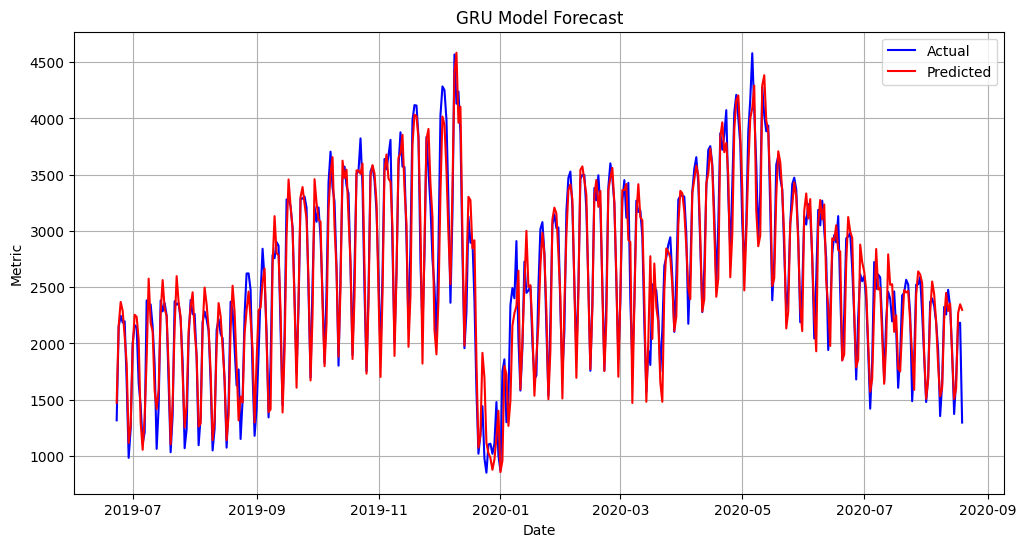

In [24]:
# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index[seq_length:], y_test, label='Actual', color='blue')
plt.plot(test.index[seq_length:], y_pred, label='Predicted', color='red')
plt.title('GRU Model Forecast')
plt.xlabel('Date')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()

# Hybrid Model (ARIMA + Neural Network)
Here's an example of a hybrid model that combines an ARIMA model with a neural network for time series forecasting:

In [26]:
model = auto_arima(data, seasonal=False, stepwise=True, suppress_warnings=True)

best_order = model.order
print("Best ARIMA Order:", best_order)

Best ARIMA Order: (5, 1, 2)


In [40]:
scaler = MinMaxScaler()
data['First.Time.Visits'] = scaler.fit_transform(data[['First.Time.Visits']])

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit an ARIMA model to the training data
order = (5, 1, 2)  # Example ARIMA order (p, d, q)
model_arima = ARIMA(train, order=order)
model_arima_fit = model_arima.fit()

# Make predictions on the test set
y_pred_arima = model_arima_fit.forecast(steps=len(test))
y_pred_arima = y_pred_arima.values.reshape(-1, 1)  # Convert to NumPy array and reshape
y_pred_arima = scaler.inverse_transform(y_pred_arima)  # Inverse transform


# Prepare data for training a neural network
X_train, y_train = train.iloc[:-1], train.iloc[1:]
X_test, y_test = test.iloc[:-1], test.iloc[1:]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
# Build and train a simple neural network
model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_dim=1))
model_nn.add(Dense(128, activation='relu'))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(1))
model_nn.compile(optimizer='adam', loss='mean_squared_error')
model_nn.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2)

y_pred_nn = model_nn.predict(X_test)
# Ensure that y_pred_arima and y_pred_nn have the same length
min_length = min(len(y_pred_arima), len(y_pred_nn))
y_pred_arima = y_pred_arima[:min_length]
y_pred_nn = y_pred_nn[:min_length]

# Perform element-wise addition and division
y_pred_hybrid = (y_pred_arima + y_pred_nn) / 2

# Calculate RMSE for the hybrid model
rmse_hybrid = np.sqrt(mean_squared_error(y_test[:min_length], y_pred_hybrid))
print(f"Root Mean Squared Error (RMSE) for Hybrid Model: {rmse_hybrid:.2f}")

Epoch 1/50
28/28 - 2s - loss: 0.0678 - 2s/epoch - 54ms/step
Epoch 2/50
28/28 - 0s - loss: 0.0186 - 94ms/epoch - 3ms/step
Epoch 3/50
28/28 - 0s - loss: 0.0176 - 85ms/epoch - 3ms/step
Epoch 4/50
28/28 - 0s - loss: 0.0174 - 79ms/epoch - 3ms/step
Epoch 5/50
28/28 - 0s - loss: 0.0174 - 70ms/epoch - 3ms/step
Epoch 6/50
28/28 - 0s - loss: 0.0175 - 86ms/epoch - 3ms/step
Epoch 7/50
28/28 - 0s - loss: 0.0176 - 82ms/epoch - 3ms/step
Epoch 8/50
28/28 - 0s - loss: 0.0175 - 80ms/epoch - 3ms/step
Epoch 9/50
28/28 - 0s - loss: 0.0173 - 89ms/epoch - 3ms/step
Epoch 10/50
28/28 - 0s - loss: 0.0174 - 79ms/epoch - 3ms/step
Epoch 11/50
28/28 - 0s - loss: 0.0173 - 99ms/epoch - 4ms/step
Epoch 12/50
28/28 - 0s - loss: 0.0173 - 77ms/epoch - 3ms/step
Epoch 13/50
28/28 - 0s - loss: 0.0173 - 71ms/epoch - 3ms/step
Epoch 14/50
28/28 - 0s - loss: 0.0177 - 87ms/epoch - 3ms/step
Epoch 15/50
28/28 - 0s - loss: 0.0173 - 77ms/epoch - 3ms/step
Epoch 16/50
28/28 - 0s - loss: 0.0173 - 70ms/epoch - 3ms/step
Epoch 17/50
28/28 

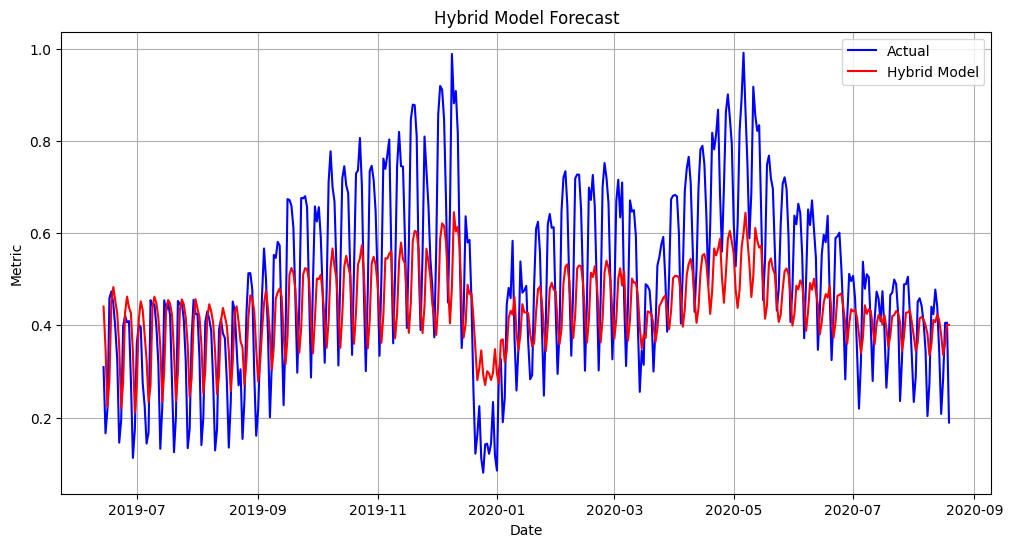

In [42]:
# Plot the actual vs. hybrid model predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[1:], y_test, label='Actual', color='blue')
plt.plot(test.index[1:], y_pred_hybrid, label='Hybrid Model', color='red')
plt.title('Hybrid Model Forecast')
plt.xlabel('Date')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()